# How to use your Model with Emukit

Blah blah test


In this tutorial we will show how to use Emukit with the models obtained from third-party, external packages. You will see that as long as your model is written in Python, it does not matter which modelling framework you are using - Emukit can still work with it. All you need is to "apply some glue"!

In [1]:
import numpy as np

from emukit.experimental_design.model_based.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

We will use exact same example as in the [introduction tutorial](Emukit-intro.ipynb), but this time instead of GPy we will use Gaussian Process implementation from [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html). Note that you will need to have scikit-learn installed in order to run this notebook.

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
x_min = -30.0
x_max = 30.0

X = np.random.uniform(x_min, x_max, (10, 1))
Y = np.sin(X) + np.random.randn(10, 1) * 0.05
sklearn_gp = GaussianProcessRegressor();
sklearn_gp.fit(X, Y);

Emukit does not provide a ready-made wrapper for scikit-learn models, as well as for many other modelling libraries. Instead it declares interfaces that each method requires in order to be able to work with the model. If the model can implement these interfaces, Emukit will be able to carry out its task. So let's see how to make our scikit-learn model work with Emukit. 

Emukit components use interfaces to declare their dependencies and what is required from them, including models. As a rule of thumb, normally all models should implement the `IModel` interface, in addition to specific interfaces the designated task requires. In our simple example we use `ExperimentalDesignLoop`, which requires a model to implement `IModel` only, and the default acquisition `ModelVariance`, which supports models that implement solely `IModel` as well. So `IModel` is the only interface we need to implement for the time being.

In [4]:
from emukit.core.interfaces import IModel

class SklearnGPModel(IModel):
    def __init__(self, sklearn_model):
        self.model = sklearn_model

    def predict(self, X):
        return self.model.predict(X, return_std=True)

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass
    
    @property
    def X(self) -> np.ndarray:
        return self.model.X_train_
    
    @property
    def Y(self) -> np.ndarray:
        return self.model.y_train_

emukit_model = SklearnGPModel(sklearn_gp)

More details about interfaces that Emukit components require can be found in their documentation.

Now we can proceed with the rest of Emukit setup.

In [5]:
p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])

loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 30)

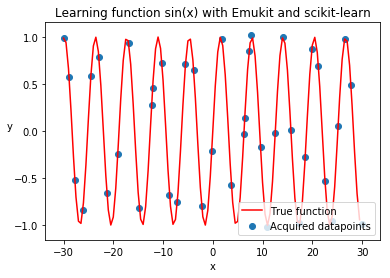

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

real_x = np.arange(x_min, x_max, 0.5)
real_y = np.sin(real_x)

plt.title('Learning function sin(x) with Emukit and scikit-learn')
plt.xlabel('x')
plt.ylabel('y', rotation=None)

plt.plot(real_x, real_y, c='r')
plt.scatter(loop.loop_state.X[:, 0].tolist(), loop.loop_state.Y[:, 0].tolist())
plt.legend(['True function', 'Acquired datapoints'], loc='lower right');

Let's plot the trained scikit-learn model, to see how well it learned the function. The code here is exactly the same as in the introduction, because we are able to use Emukit model interface.

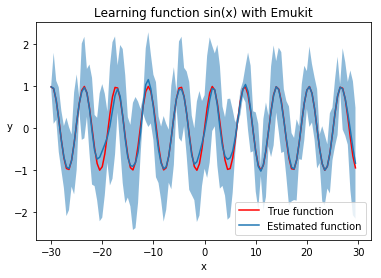

In [7]:
predicted_y = []
predicted_std = []
for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()
    
plt.title('Learning function sin(x) with Emukit')
plt.xlabel('x')
plt.ylabel('y', rotation=None)
plt.plot(real_x, real_y, c='r', )
plt.plot(real_x, predicted_y)
plt.legend(['True function', 'Estimated function'], loc='lower right')
plt.fill_between(real_x, predicted_y - 2 * predicted_std, predicted_y + 2 * predicted_std, alpha=.5);